# MTH-IDS Adoption Using UNSW-NB15
This is an adoption of the method described in the paper entitled "[**MTH-IDS: A Multi-Tiered Hybrid Intrusion Detection System for Internet of Vehicles**](https://arxiv.org/pdf/2105.13289.pdf)" accepted in IEEE Internet of Things Journal using UNSW-NB15 dataset to test its performance.  

## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

## Read the UNSW-NB15 dataset
The UNSW-NB15 dataset is publicly available at: https://research.unsw.edu.au/projects/unsw-nb15-dataset  
This notebook uses a merged version of the dataset, please firstly run Prepare_UNSW-NB15_Dataset.ipynb to automatically download the dataset and do the merge  
*Note: This project downloads the dataset from Kaggle, which is found to be just a copy of the original dataset*

In [3]:
#Read dataset
df = pd.read_csv('data/UNSW-NB15.csv')

In [4]:
df

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390.0,149.171.126.6,53.0,udp,CON,0.001055,132,164,31,...,0.0,3,7,1,3,1,1,1,Normal,0
1,59.166.0.0,33661.0,149.171.126.9,1024.0,udp,CON,0.036133,528,304,31,...,0.0,2,4,2,3,1,1,2,Normal,0
2,59.166.0.6,1464.0,149.171.126.7,53.0,udp,CON,0.001119,146,178,31,...,0.0,12,8,1,2,2,1,1,Normal,0
3,59.166.0.5,3593.0,149.171.126.5,53.0,udp,CON,0.001209,132,164,31,...,0.0,6,9,1,1,1,1,1,Normal,0
4,59.166.0.3,49664.0,149.171.126.0,53.0,udp,CON,0.001169,146,178,31,...,0.0,7,9,1,1,1,1,1,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539734,59.166.0.5,33094.0,149.171.126.7,43433.0,tcp,FIN,0.087306,320,1828,31,...,-1.0,1,2,3,3,1,1,3,Normal,0
2539735,59.166.0.7,20848.0,149.171.126.4,21.0,tcp,CON,0.365058,456,346,31,...,2.0,2,2,2,2,2,2,2,Normal,0
2539736,59.166.0.3,21511.0,149.171.126.9,21.0,tcp,CON,6.335154,1802,2088,31,...,2.0,2,2,4,2,2,2,2,Normal,0
2539737,59.166.0.9,35433.0,149.171.126.0,80.0,tcp,CON,2.200934,3498,166054,31,...,-1.0,1,1,2,4,2,2,2,Normal,0


In [5]:
df['attack_cat'].value_counts()

Normal            2218456
Generic            215481
Exploits            44525
Fuzzers             24246
DoS                 16353
Reconnaissance      13987
Analysis             2677
Backdoor             1795
Shellcode            1511
Backdoors             534
Worms                 174
Name: attack_cat, dtype: int64

### Early Feature Selection (remove useless features in the dataset)
Refering to the training set included in the files downloaded from Kaggle

In [6]:
# # Read the downloaded training set
# df_training = pd.read_csv('data/achieve/UNSW_NB15_training-set.csv', index_col='id')
# # Get feature set
# features = df_training.columns.to_list()
# # Adjustments
# # Rename some feature names to match the complete dataset
# rename_dict = {
#     'smean': 'smeansz',
#     'dmean': 'dmeansz',
#     'response_body_len': 'res_bdy_len',
#     'sinpkt': 'sintpkt',
#     'dinpkt': 'dintpkt'
# }
# features = list(map(lambda x: rename_dict[x] if x in rename_dict else x, features))
# # Remove feature 'rate' since it is not in the dataset
# features.remove('rate')
# # Remove feature 'label' to match the original code of MTH-IDS_IoTJ
# features.remove('label')
# # Release Memory
# del df_training

# For convenience
features = ['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
 'sintpkt', 'dintpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smeansz', 'dmeansz', 'trans_depth',
 'res_bdy_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login',
 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat']

print(features)

['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sintpkt', 'dintpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat']


In [7]:
# Only keep the influencing features
df = df[features]

### Preprocessing (normalization and padding values)

In [8]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

### Data sampling
Due to the space limit of GitHub files and the large size of network traffic data, we sample a small-sized subset for model learning using **k-means cluster sampling**

In [9]:
labelencoder = LabelEncoder()
for col_name in df.dtypes[df.dtypes == 'object'].index:
      df[col_name] = labelencoder.fit_transform(df[col_name])

In [10]:
df['attack_cat'].value_counts()

7     2218456
6      215481
4       44525
5       24246
3       16353
8       13987
0        2677
1        1795
9        1511
2         534
10        174
Name: attack_cat, dtype: int64

In [11]:
# retain the minority class instances and sample the majority class instances
df_minor = df[(df['attack_cat']==0)|(df['attack_cat']==1)|(df['attack_cat']==9)|(df['attack_cat']==2)|(df['attack_cat']==10)]
df_major = df.drop(df_minor.index)

In [12]:
X = df_major.drop(['attack_cat'],axis=1) 
y = df_major.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [13]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

In [14]:
klabel=kmeans.labels_
df_major['klabel']=klabel

In [15]:
df_major['klabel'].value_counts()

112    13394
55     10841
367    10733
444    10027
818     9372
       ...  
894      102
639       98
140       80
637       72
370       11
Name: klabel, Length: 999, dtype: int64

In [16]:
cols = list(df_major)
cols.insert(41, cols.pop(cols.index('attack_cat')))
df_major = df_major.loc[:, cols]

In [17]:
df_major

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,sttl,dttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,klabel
0,-0.047237,119,2,2,-0.410191,-0.335218,-0.074599,-0.225120,-0.425873,-0.041315,...,-0.419941,-0.519288,1.024811,0.984974,0.511771,-0.475500,-0.183860,-0.040675,7,427
1,-0.044718,119,0,2,-0.383975,-0.318758,-0.067579,-0.224251,-0.425873,-0.041315,...,-0.419941,-0.430468,1.024811,0.984974,0.511771,-0.475500,-0.461052,-0.040675,7,957
2,-0.047232,119,2,2,-0.410191,-0.335218,-0.074351,-0.225033,-0.425873,-0.041315,...,-0.419941,-0.519288,1.024811,0.984974,0.511771,-0.597372,-0.091463,-0.040675,7,290
3,-0.047226,119,2,2,-0.410191,-0.335218,-0.074599,-0.225120,-0.425873,-0.041315,...,-0.419941,-0.519288,1.024811,0.984974,0.511771,-0.719244,0.000935,-0.040675,7,427
4,-0.047229,119,2,2,-0.410191,-0.335218,-0.074351,-0.225033,-0.425873,-0.041315,...,-0.419941,-0.519288,1.024811,0.984974,0.511771,-0.719244,0.000935,-0.040675,7,427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539734,-0.041043,113,4,5,-0.357758,-0.285839,-0.071266,-0.214791,-0.425873,-0.041315,...,-0.419941,-0.341649,-0.853666,-0.831158,-0.704894,-0.475500,-0.645847,-0.040675,7,747
2539735,-0.021098,113,3,2,-0.331542,-0.302299,-0.068855,-0.223990,-0.425873,-0.041315,...,-0.257991,-0.430468,4.781765,4.617237,-0.704894,-0.597372,-0.645847,-0.040675,7,507
2539736,0.407611,113,3,2,-0.016943,-0.104781,-0.044994,-0.213177,-0.425873,-0.041315,...,-0.257991,-0.430468,4.781765,4.617237,-0.704894,-0.597372,-0.645847,-0.040675,7,507
2539737,0.110735,113,5,2,0.323872,0.602988,-0.014928,0.804579,-0.425873,-0.041315,...,-0.257991,-0.430468,-0.853666,-0.831158,2.945100,-0.353628,-0.738245,-0.040675,7,871


In [18]:
def typicalSampling(group):
    name = group.name
    frac = 0.024
    return group.sample(frac=frac)

result = df_major.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

In [19]:
result['attack_cat'].value_counts()

7    53242
6     5162
4     1079
5      621
3      366
8      328
Name: attack_cat, dtype: int64

In [20]:
result

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,sttl,dttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,klabel
1052464,-0.044645,119,0,2,-0.383975,-0.318758,-0.067295,-0.224251,-0.425873,-0.041315,...,-0.419941,-0.341649,1.024811,0.984974,0.511771,-0.353628,0.462922,-0.040675,7,0
508588,-0.046964,119,0,2,-0.383975,-0.318758,-0.066870,-0.224152,-0.425873,-0.041315,...,-0.419941,-0.341649,1.024811,0.984974,0.511771,-0.475500,0.555319,-0.040675,7,0
696068,-0.046968,119,0,2,-0.383975,-0.318758,-0.066870,-0.224152,-0.425873,-0.041315,...,-0.419941,-0.341649,1.024811,0.984974,0.511771,-0.475500,0.647717,-0.040675,7,0
357113,-0.047189,119,0,2,-0.383975,-0.318758,-0.067579,-0.224251,-0.425873,-0.041315,...,-0.419941,-0.430468,1.024811,0.984974,0.511771,0.255731,0.647717,-0.040675,7,0
315358,-0.030838,119,0,2,-0.383975,-0.318758,-0.066870,-0.224201,-0.425873,-0.041315,...,-0.419941,-0.341649,1.024811,0.984974,0.511771,-0.109885,0.370524,-0.040675,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468214,-0.044371,113,0,5,0.166572,0.043356,-0.026344,-0.044778,-0.425873,-0.041315,...,0.065908,-0.252830,1.024811,0.984974,0.511771,1.108834,0.185730,-0.040675,7,999
186833,-0.041649,113,0,5,0.586037,0.306713,0.003722,0.192098,-0.425873,-0.041315,...,-0.419941,-0.519288,1.024811,0.984974,0.511771,0.621347,0.000935,-0.040675,7,999
438159,-0.041329,113,0,5,0.428738,0.207954,-0.007340,0.121597,-0.425873,-0.041315,...,0.065908,-0.075191,1.024811,0.984974,0.511771,1.108834,0.093332,-0.040675,7,999
430036,-0.045639,113,0,5,0.192789,0.059816,-0.024501,-0.023873,-0.425873,-0.041315,...,0.065908,-0.252830,1.024811,0.984974,0.511771,0.986962,-0.461052,-0.040675,7,999


In [21]:
result = result.drop(['klabel'],axis=1)
result = result.append(df_minor)

In [22]:
result.to_csv('./data/UNSW-NB15_sample_km.csv',index=0)

### split train set and test set

In [23]:
df=pd.read_csv('./data/UNSW-NB15_sample_km.csv')

In [24]:
X = df.drop(['attack_cat'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

## Feature engineering

In [26]:
# Prepare the result output
output_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Time'])
output_index = list()

### Feature selection by information gain

In [27]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [28]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [29]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [30]:
X_fs = df[fs].values

In [31]:
X_fs.shape

(67489, 28)

### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [32]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [33]:
start_time = time.time()
X_fss = fcbf.fit_transform(X_fs,y)
end_time = time.time()

In [34]:
# Add to output sheet
result_dict = {
    'Accuracy': np.NaN,
    'Precision': np.NaN,
    'Recall': np.NaN,
    'F1-Score': np.NaN,
    'Time': end_time-start_time
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('FCBF')

In [35]:
X_fss.shape

(67489, 20)

### Re-split train & test sets after feature selection

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [37]:
X_train.shape

(53991, 20)

In [38]:
pd.Series(y_train).value_counts()

7     42593
6      4130
0      2142
1      1436
9      1209
4       863
5       497
2       427
3       293
8       262
10      139
dtype: int64

### SMOTE to solve class-imbalance

In [39]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={4:1000,5:1000,2:1000,3:1000,8:1000,10:1000})

In [40]:
X_train, y_train = smote.fit_sample(X_train, y_train)

In [41]:
pd.Series(y_train).value_counts()

7     42593
6      4130
0      2142
1      1436
9      1209
3      1000
5      1000
8      1000
4      1000
2      1000
10     1000
dtype: int64

In [42]:
X_combined = np.concatenate((X_train, X_test), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

#### Apply XGBoost

[22:36:30] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBoost: 0.9419914061342421
Precision of XGBoost: 0.9464308134969464
Recall of XGBoost: 0.9419914061342421
F1-score of XGBoost: 0.9385393229973737
              precision    recall  f1-score   support

           0       0.52      0.79      0.63       536
           1       0.67      0.23      0.34       359
           2       0.50      0.96      0.66       107
           3       0.04      0.01      0.02        79
           4       0.80      0.42      0.55       204
           5       0.48      0.63      0.54       126
           6       0.99      0.97      0.98      1036
           7       1.00      0.99      0.99     10652
           8       0.72      0.76      0.74        62
          

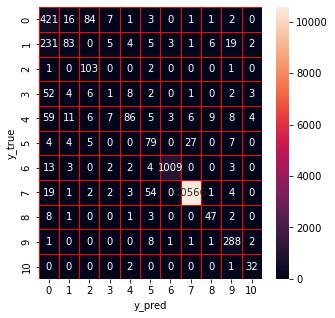

In [85]:
xg = xgb.XGBClassifier(n_estimators = 10)
start_time = time.time()
xg.fit(X_train,y_train)
end_time = time.time()
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [86]:
# Add to output sheet
result_dict = {
    'Accuracy': xg_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Time': end_time-start_time
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('XGBoost (Original)')

#### Hyperparameter optimization (HPO) of XGBoost using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [87]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

start_time = time.time()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

end_time = time.time()

print("XGBoost: Hyperopt estimated optimum {}".format(best))

[22:36:35] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:36:39] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:36:50] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:37:35] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation

[22:44:20] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBoost: 0.9328789450288931
Precision of XGBoost: 0.9339026375840774
Recall of XGBoost: 0.9328789450288931
F1-score of XGBoost: 0.9323265046918341
              precision    recall  f1-score   support

           0       0.44      0.56      0.49       536
           1       0.35      0.26      0.30       359
           2       0.41      0.66      0.51       107
           3       0.12      0.06      0.08        79
           4       0.70      0.48      0.57       204
           5       0.52      0.56      0.54       126
           6       0.99      0.98      0.98      1036
           7       0.99      0.99      0.99     10652
           8       0.81      0.74      0.77        62
          

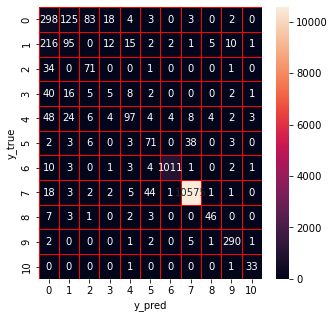

In [88]:
params = {
    'n_estimators': int(best['n_estimators']), 
    'max_depth': int(best['max_depth']),
    'learning_rate':  abs(float(best['learning_rate'])),
}
xg = xgb.XGBClassifier(**params)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [89]:
# Add to output sheet
result_dict = {
    'Accuracy': xg_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Time': end_time-start_time
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('XGBoost (BO-TPE)')

In [90]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

#### Hyperparameter optimization (HPO) of XGBoost using Particle Swarm Optimization (PSO)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [91]:
#XGBoost
import optunity
import optunity.metrics

data= X_combined
labels= y_combined.tolist()
Y_train = y_train
Y_test = y_test
# Define the hyperparameter configuration space
search = {
    'n_estimators': [10, 100],
    'max_depth': [5,50],
    'learning_rate': [0.01, 0.9]
}
# Define the objective function
@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance(x_train, y_train, x_test, y_test,n_estimators=None, max_depth=None,learning_rate=None):
    # fit the model
    params = {
        'n_estimators': int(n_estimators), 
        'max_depth': int(max_depth),
        'learning_rate':  abs(float(learning_rate)),
    }
    model = xgb.XGBClassifier( **params)
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    # scores=np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
    #                                 scoring="accuracy"))
    #return optunity.metrics.roc_auc(y_test, predictions, positive=True)
    return optunity.metrics.accuracy(Y_test, predictions)

start_time = time.time()

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )

end_time = time.time()

print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

{'n_estimators': 62.12903818237285, 'max_depth': 7.564702519365953, 'learning_rate': 0.3575693359375}
Accuracy:0.9187573410820722


[23:52:28] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBoost: 0.9367313676100163
Precision of XGBoost: 0.9370425392689099
Recall of XGBoost: 0.9367313676100163
F1-score of XGBoost: 0.9350752214706989
              precision    recall  f1-score   support

           0       0.47      0.63      0.54       536
           1       0.38      0.25      0.30       359
           2       0.46      0.80      0.59       107
           3       0.08      0.03      0.04        79
           4       0.73      0.47      0.57       204
           5       0.51      0.60      0.55       126
           6       0.99      0.98      0.98      1036
           7       1.00      0.99      0.99     10652
           8       0.84      0.74      0.79        62
          

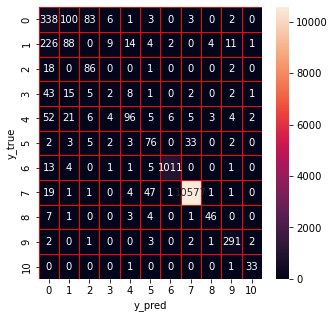

In [92]:
params = {
    'n_estimators': int(optimal_configuration['n_estimators']), 
    'max_depth': int(optimal_configuration['max_depth']), 
    'learning_rate': abs(float(optimal_configuration['learning_rate']))
}
xg = xgb.XGBClassifier(**params)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [93]:
# Add to output sheet
result_dict = {
    'Accuracy': xg_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Time': end_time-start_time
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('XGBoost (PSO)')

#### Hyperparameter optimization (HPO) of XGBoost using Genetic Algorithm (GA)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [97]:
#Xgboost
from tpot import TPOTClassifier
# Define the hyperparameter configuration space
parameters = {
    'n_estimators': range(10,100),
    'max_depth': range(4,100),
    'learning_rate': [i/100 for i in range(1, 90)]
}
# Set the hyperparameters of GA                 
ga = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'xgboost.XGBClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
start_time = time.time()
ga.fit(X_combined, y_combined)
end_time = time.time()

1 operators have been imported by TPOT.
[23:59:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:59:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:59:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:59:11] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting 

In [54]:
# Helper method: convert the values represented by string to its correct type
def type_str(input_str:str):
    # is integer
    if input_str.isdecimal():
        return int(input_str)
    # is float
    elif input_str.isdigit():
        return float(input_str)
    # is string
    elif input_str.startswith('"') and input_str.endswith('"'):
        # remove quotation marks
        return input_str[1: -1]
    else:
        return input_str

# Extract the optimized parameter from the generated pipeline
def get_ga_optimized_parameters(fitted_tpot_obj: TPOTClassifier, classifier_name: str, temp_file_name:str='temp_ga_pipeline.py'):
    # Export the pipeline
    fitted_tpot_obj.export(output_file_name=temp_file_name)
    # Read the optimized pipeline
    with open(temp_file_name) as temp_file:
        lines = temp_file.readlines()
    for line in lines:
        if classifier_name+'(' in line.strip():
            pipeline = line
            break
    # Extract the optimized parameters
    start_index = pipeline.index(classifier_name+'(')
    end_index = pipeline.index(')')
    parameters_str = pipeline[start_index+len(classifier_name)+1: end_index]
    parameters = dict()
    for temp_str in parameters_str.split(sep=','):
        temp_list = temp_str.split('=')
        parameters[temp_list[0].strip()] = type_str(temp_list[1].strip())
    # Delect the temp file
    os.remove(temp_file_name)
    # Return the optimized parameters
    return parameters

In [ ]:
xg = xgb.XGBClassifier(**get_ga_optimized_parameters(ga, 'XGBClassifier'))
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': xg_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Time': end_time-start_time
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('XGBoost (GA)')

#### Apply RF

Accuracy of RF: 0.9339161357238109
Precision of RF: 0.9349308548885727
Recall of RF: 0.9339161357238109
F1-score of RF: 0.9333519631755297
              precision    recall  f1-score   support

           0       0.46      0.58      0.51       535
           1       0.34      0.25      0.28       359
           2       0.46      0.75      0.57       107
           3       0.10      0.07      0.08        73
           4       0.70      0.50      0.59       216
           5       0.52      0.54      0.53       124
           6       1.00      0.97      0.99      1032
           7       1.00      0.99      0.99     10649
           8       0.87      0.79      0.83        66
           9       0.89      0.96      0.92       302
          10       0.80      0.94      0.87        35

    accuracy                           0.93     13498
   macro avg       0.65      0.67      0.65     13498
weighted avg       0.93      0.93      0.93     13498



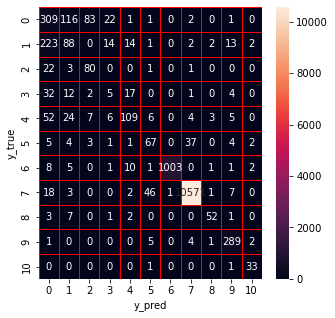

In [43]:
rf = RandomForestClassifier(random_state = 0)
start_time = time.time()
rf.fit(X_train,y_train)
end_time = time.time() 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [44]:
# Add to output sheet
result_dict = {
    'Accuracy': rf_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Time': end_time-start_time
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('RF (Original)')

#### Hyperparameter optimization (HPO) of random forest using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [45]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
available_criterion = ['gini','entropy']
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion', available_criterion)
}

start_time = time.time()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

end_time = time.time()

print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [03:25<00:00, 10.27s/trial, best loss: -0.942584086531338] 
Random Forest: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 12.0, 'max_features': 13.0, 'min_samples_leaf': 6.0, 'min_samples_split': 8.0, 'n_estimators': 62.0}


Accuracy of RF: 0.9413246406875092
Precision of RF: 0.944240452028322
Recall of RF: 0.9413246406875092
F1-score of RF: 0.9386178860964776
              precision    recall  f1-score   support

           0       0.52      0.75      0.61       535
           1       0.54      0.25      0.34       359
           2       0.51      0.98      0.68       107
           3       0.31      0.05      0.09        73
           4       0.76      0.46      0.57       216
           5       0.49      0.65      0.56       124
           6       1.00      0.97      0.98      1032
           7       1.00      0.99      0.99     10649
           8       0.76      0.85      0.80        66
           9       0.84      0.94      0.88       302
          10       0.68      0.91      0.78        35

    accuracy                           0.94     13498
   macro avg       0.67      0.71      0.66     13498
weighted avg       0.94      0.94      0.94     13498



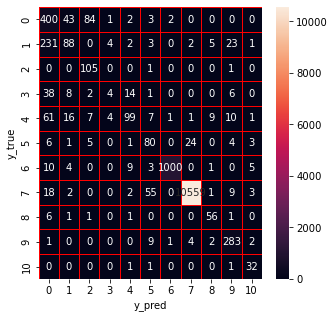

In [46]:
params = {
    'n_estimators': int(best['n_estimators']), 
    'max_depth': int(best['max_depth']),
    'max_features': int(best['max_features']),
    "min_samples_split":int(best['min_samples_split']),
    "min_samples_leaf":int(best['min_samples_leaf']),
    "criterion":available_criterion[int(best['criterion'])]
}
rf_hpo = RandomForestClassifier(**params)
rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [47]:
# Add to output sheet
result_dict = {
    'Accuracy': rf_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Time': end_time-start_time
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('RF (BO-TPE)')

In [48]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

#### Hyperparameter optimization (HPO) of random forest using Particle Swarm Optimization (PSO)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [49]:
#Random Forest
import optunity
import optunity.metrics

data=X
labels=y.tolist()
Y_train = y_train
Y_test = y_test
# Define the hyperparameter configuration space
search = {
    'n_estimators': [10, 100],
    'max_features': [1, 20],
    'max_depth': [5,50],
    "min_samples_split":[2,11],
    "min_samples_leaf":[1,11],
    "criterion":[0,1]
         }
available_criterion = ['gini', 'entropy']
# Define the objective function
@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance(x_train, y_train, x_test, y_test,n_estimators=None, max_features=None,max_depth=None,min_samples_split=None,min_samples_leaf=None,criterion=None):
    # fit the model
    if criterion<0.5:
        cri=available_criterion[0]
    else:
        cri=available_criterion[1]
    model = RandomForestClassifier(n_estimators=int(n_estimators),
                                   max_features=int(max_features),
                                   max_depth=int(max_depth),
                                   min_samples_split=int(min_samples_split),
                                   min_samples_leaf=int(min_samples_leaf),
                                   criterion=cri,
                                  )
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    # scores=np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
    #                                 scoring="accuracy"))
    #return optunity.metrics.roc_auc(y_test, predictions, positive=True)
    return optunity.metrics.accuracy(Y_test, predictions)

start_time = time.time()

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )

end_time = time.time()

print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

{'n_estimators': 51.30859375, 'max_features': 3.634765625, 'max_depth': 16.865234375, 'min_samples_split': 7.220703125, 'min_samples_leaf': 8.87109375, 'criterion': 0.896484375}
Accuracy:0.9420407961673335


Accuracy of RF: 0.9422136612831531
Precision of RF: 0.9465924092938208
Recall of RF: 0.9422136612831531
F1-score of RF: 0.9386356398629404
              precision    recall  f1-score   support

           0       0.52      0.79      0.63       535
           1       0.66      0.23      0.34       359
           2       0.50      0.91      0.65       107
           3       0.40      0.03      0.05        73
           4       0.69      0.45      0.55       216
           5       0.53      0.64      0.58       124
           6       1.00      0.97      0.98      1032
           7       1.00      0.99      0.99     10649
           8       0.77      0.85      0.81        66
           9       0.83      0.94      0.88       302
          10       0.52      0.89      0.65        35

    accuracy                           0.94     13498
   macro avg       0.67      0.70      0.65     13498
weighted avg       0.95      0.94      0.94     13498



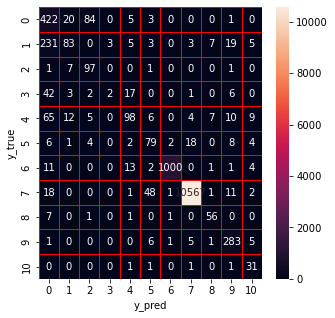

In [50]:
params = {
    'n_estimators': int(optimal_configuration['n_estimators']), 
    'min_samples_leaf': int(optimal_configuration['min_samples_leaf']), 
    'max_depth': int(optimal_configuration['max_depth']), 
    'min_samples_split': int(optimal_configuration['min_samples_split']), 
    'max_features': int(optimal_configuration['max_features']), 
    'criterion': available_criterion[int(optimal_configuration['criterion']+0.5)]
}
rf_hpo = RandomForestClassifier(**params)
rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [51]:
# Add to output sheet
result_dict = {
    'Accuracy': rf_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Time': end_time-start_time
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('RF (PSO)')

#### Hyperparameter optimization (HPO) of random forest using Genetic Algorithm (GA)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [52]:
#Random Forest
from tpot import TPOTClassifier
# Define the hyperparameter configuration space
parameters = {
    'n_estimators': range(20,200),
    "max_features":range(1,20),
    'max_depth': range(10,100),
    "min_samples_split":range(2,11),
    "min_samples_leaf":range(1,11),
    "criterion":['gini','entropy']
             }
# Set the hyperparameters of GA                 
ga = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.ensemble.RandomForestClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
start_time = time.time()
ga.fit(X_combined, y_combined)
end_time = time.time()

1 operators have been imported by TPOT.
                                                                            
Generation 1 - Current Pareto front scores:
                                                                            
-1	0.9304163357178427	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=15, RandomForestClassifier__max_features=7, RandomForestClassifier__min_samples_leaf=3, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=81)
                                                                            
Generation 2 - Current Pareto front scores:
                                                                            
-1	0.9304163357178427	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=15, RandomForestClassifier__max_features=7, RandomForestClassifier

Accuracy of RF: 0.9396947695954956
Precision of RF: 0.9412391157715357
Recall of RF: 0.9396947695954956
F1-score of RF: 0.9378138291293365
              precision    recall  f1-score   support

           0       0.50      0.69      0.58       535
           1       0.47      0.26      0.33       359
           2       0.50      0.91      0.64       107
           3       0.25      0.07      0.11        73
           4       0.72      0.50      0.59       216
           5       0.50      0.62      0.56       124
           6       1.00      0.97      0.98      1032
           7       1.00      0.99      0.99     10649
           8       0.85      0.83      0.84        66
           9       0.84      0.94      0.89       302
          10       0.73      0.91      0.81        35

    accuracy                           0.94     13498
   macro avg       0.67      0.70      0.67     13498
weighted avg       0.94      0.94      0.94     13498



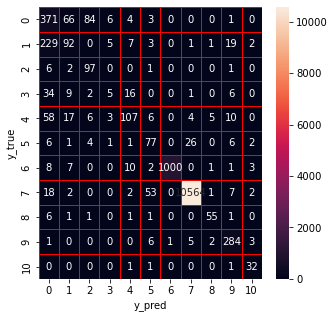

In [56]:
rf_hpo = RandomForestClassifier(**get_ga_optimized_parameters(ga, 'RandomForestClassifier'))
rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': rf_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Time': end_time-start_time
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('RF (GA)')

#### Apply DT

Accuracy of DT: 0.9252481849162839
Precision of DT: 0.9257031294401957
Recall of DT: 0.9252481849162839
F1-score of DT: 0.924588163155752
              precision    recall  f1-score   support

           0       0.41      0.54      0.47       536
           1       0.28      0.21      0.24       359
           2       0.45      0.59      0.51       107
           3       0.04      0.03      0.03        73
           4       0.63      0.45      0.52       215
           5       0.45      0.46      0.46       127
           6       0.99      0.98      0.98      1034
           7       0.99      0.99      0.99     10646
           8       0.76      0.66      0.71        64
           9       0.85      0.86      0.85       302
          10       0.83      0.86      0.85        35

    accuracy                           0.93     13498
   macro avg       0.61      0.60      0.60     13498
weighted avg       0.93      0.93      0.92     13498



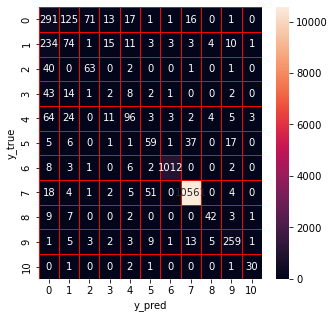

In [55]:
dt = DecisionTreeClassifier(random_state = 0)
start_time = time.time()
dt.fit(X_train,y_train)
end_time = time.time() 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': dt_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Time': end_time-start_time
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('DT (Original)')

#### Hyperparameter optimization (HPO) of decision tree using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [56]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
available_criterion = ['gini','entropy']
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',available_criterion)
}

start_time = time.time()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

end_time = time.time()

print("Decision tree: Hyperopt estimated optimum {}".format(best))

100%|██████████| 50/50 [00:10<00:00,  4.70trial/s, best loss: -0.937842643354571] 
Decision tree: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 10.0, 'max_features': 14.0, 'min_samples_leaf': 3.0, 'min_samples_split': 3.0}


Accuracy of DT: 0.9375463031560232
Precision of DT: 0.943092848462321
Recall of DT: 0.9375463031560232
F1-score of DT: 0.935396470669343
              precision    recall  f1-score   support

           0       0.52      0.76      0.62       536
           1       0.59      0.24      0.34       359
           2       0.53      0.94      0.68       107
           3       0.13      0.05      0.08        73
           4       0.82      0.41      0.55       215
           5       0.45      0.73      0.56       127
           6       1.00      0.97      0.98      1034
           7       1.00      0.99      0.99     10646
           8       0.52      0.70      0.60        64
           9       0.80      0.87      0.83       302
          10       0.72      0.89      0.79        35

    accuracy                           0.94     13498
   macro avg       0.64      0.69      0.64     13498
weighted avg       0.94      0.94      0.94     13498



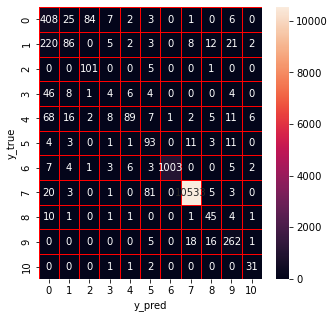

In [57]:
params = {
    'max_depth': int(best['max_depth']),
    'max_features': int(best['max_features']),
    "min_samples_split":int(best['min_samples_split']),
    "min_samples_leaf":int(best['min_samples_leaf']),
    "criterion":available_criterion[int(best['criterion'])]
}
dt_hpo = DecisionTreeClassifier(**params)
dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': dt_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Time': end_time-start_time
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('DT (BO-TPE)')

In [58]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

#### Hyperparameter optimization (HPO) of decision tree using Particle Swarm Optimization (PSO)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
#Random Forest
import optunity
import optunity.metrics

data=X_train
labels=y_train.tolist()
Y_train = y_train
Y_test = y_test
# Define the hyperparameter configuration space
search = {
    'max_features': [1, 20],
    'max_depth': [5,50],
    "min_samples_split":[2,11],
    "min_samples_leaf":[1,11],
    "criterion":[0,1]
}
available_criterion = ['gini', 'entropy']
# Define the objective function
@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance(x_train, y_train, x_test, y_test,max_features=None,max_depth=None,min_samples_split=None,min_samples_leaf=None,criterion=None):
    # fit the model
    if criterion<0.5:
        cri=available_criterion[0]
    else:
        cri=available_criterion[1]
    model = DecisionTreeClassifier(max_features=int(max_features),
                                   max_depth=int(max_depth),
                                   min_samples_split=int(min_samples_split),
                                   min_samples_leaf=int(min_samples_leaf),
                                   criterion=cri,
                                  )
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    # scores=np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
                                    # scoring="accuracy"))
    # return optunity.metrics.roc_auc(y_test, predictions, positive=True)
    return optunity.metrics.accuracy(Y_test, predictions)

start_time = time.time()

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )

end_time = time.time()

print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

In [ ]:
params = {
    'min_samples_leaf': int(optimal_configuration['min_samples_leaf']), 
    'max_depth': int(optimal_configuration['max_depth']), 
    'min_samples_split': int(optimal_configuration['min_samples_split']), 
    'max_features': int(optimal_configuration['max_features']), 
    'criterion': available_criterion[int(optimal_configuration['criterion']+0.5)]
}
dt_hpo = DecisionTreeClassifier(**params)
dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': dt_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Time': end_time-start_time
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('DT (PSO)')

#### Hyperparameter optimization (HPO) of decision tree using Genetic Algorithm (GA)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
#Random Forest
from tpot import TPOTClassifier
# Define the hyperparameter configuration space
parameters = {
    "max_features":range(1,20),
    'max_depth': range(10,100),
    "min_samples_split":range(2,11),
    "min_samples_leaf":range(1,11),
    "criterion":['gini','entropy']
}
# Set the hyperparameters of GA                 
ga = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.tree.DecisionTreeClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
start_time = time.time()
ga.fit(X_combined, y_combined)
end_time = time.time()

In [55]:
dt_hpo = DecisionTreeClassifier(**get_ga_optimized_parameters(ga, 'DecisionTreeClassifier'))
dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

UnboundLocalError: local variable 'pipeline' referenced before assignment

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': dt_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Time': end_time-start_time
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('DT (GA)')

#### Apply ET

Accuracy of ET: 0.9310268187879686
Precision of ET: 0.9320035200974949
Recall of ET: 0.9310268187879686
F1-score of ET: 0.9301638197966925
              precision    recall  f1-score   support

           0       0.43      0.59      0.50       536
           1       0.31      0.22      0.26       359
           2       0.45      0.59      0.51       107
           3       0.07      0.04      0.05        73
           4       0.72      0.46      0.56       215
           5       0.55      0.59      0.57       127
           6       0.99      0.98      0.98      1034
           7       1.00      0.99      0.99     10646
           8       0.74      0.66      0.69        64
           9       0.85      0.95      0.90       302
          10       0.75      0.86      0.80        35

    accuracy                           0.93     13498
   macro avg       0.62      0.63      0.62     13498
weighted avg       0.93      0.93      0.93     13498



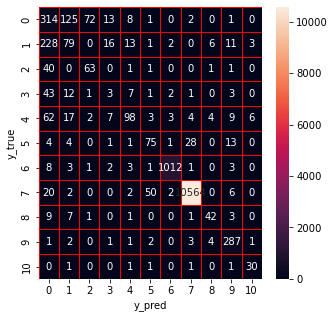

In [59]:
et = ExtraTreesClassifier(random_state = 0)
start_time = time.time()
et.fit(X_train,y_train)
end_time = time.time() 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': et_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Time': end_time-start_time
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('ET (Original)')

#### Hyperparameter optimization (HPO) of extra trees using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [60]:
# Hyperparameter optimization of extra trees
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = ExtraTreesClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
available_criterion = ['gini','entropy']
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',available_criterion)
}

start_time = time.time()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

end_time = time.time()

print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [01:03<00:00,  3.15s/trial, best loss: -0.9393243443473107]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 16.0, 'max_features': 14.0, 'min_samples_leaf': 3.0, 'min_samples_split': 10.0, 'n_estimators': 75.0}


Accuracy of ET: 0.9388057489998518
Precision of ET: 0.9424155857262476
Recall of ET: 0.9388057489998518
F1-score of ET: 0.9364766360699387
              precision    recall  f1-score   support

           0       0.50      0.73      0.60       536
           1       0.54      0.24      0.33       359
           2       0.53      0.90      0.66       107
           3       0.12      0.05      0.07        73
           4       0.83      0.43      0.56       215
           5       0.52      0.64      0.57       127
           6       0.99      0.97      0.98      1034
           7       1.00      0.99      0.99     10646
           8       0.62      0.75      0.68        64
           9       0.80      0.92      0.86       302
          10       0.62      0.91      0.74        35

    accuracy                           0.94     13498
   macro avg       0.64      0.69      0.64     13498
weighted avg       0.94      0.94      0.94     13498



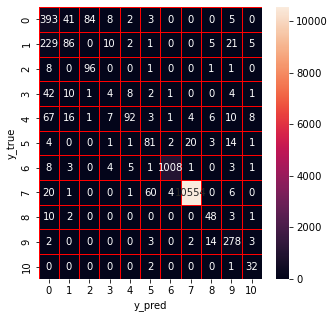

In [61]:
params = {
    'n_estimators': int(best['n_estimators']), 
    'max_depth': int(best['max_depth']),
    'max_features': int(best['max_features']),
    "min_samples_split":int(best['min_samples_split']),
    "min_samples_leaf":int(best['min_samples_leaf']),
    "criterion":available_criterion[int(best['criterion'])]
}
et_hpo = ExtraTreesClassifier(**params)
et_hpo.fit(X_train,y_train) 
et_score=et_hpo.score(X_test,y_test)
y_predict=et_hpo.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': et_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Time': end_time-start_time
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('ET (BO-TPE)')

In [62]:
et_train=et_hpo.predict(X_train)
et_test=et_hpo.predict(X_test)

#### Hyperparameter optimization (HPO) of extra trees using Particle Swarm Optimization (PSO)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
#Random Forest
import optunity
import optunity.metrics

data=X_train
labels=y_train.tolist()
Y_train = y_train
Y_test = y_test
# Define the hyperparameter configuration space
search = {
    'n_estimators': [10, 200],
    'max_features': [1, 20],
    'max_depth': [5,50],
    "min_samples_split":[2,11],
    "min_samples_leaf":[1,11],
    "criterion":[0,1]
}
available_criterion = ['gini', 'entropy']
# Define the objective function
@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance(x_train, y_train, x_test, y_test,n_estimators=None,max_features=None,max_depth=None,min_samples_split=None,min_samples_leaf=None,criterion=None):
    # fit the model
    if criterion<0.5:
        cri=available_criterion[0]
    else:
        cri=available_criterion[1]
    model = ExtraTreesClassifier(n_estimators=int(n_estimators),
                                   max_features=int(max_features),
                                   max_depth=int(max_depth),
                                   min_samples_split=int(min_samples_split),
                                   min_samples_leaf=int(min_samples_leaf),
                                   criterion=cri,
                                  )
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    # scores=np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
                                    # scoring="accuracy"))
    # return optunity.metrics.roc_auc(y_test, predictions, positive=True)
    return optunity.metrics.accuracy(Y_test, predictions)

start_time = time.time()

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )

end_time = time.time()

print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

In [ ]:
params = {
    'n_estimators': int(optimal_configuration['n_estimators']), 
    'min_samples_leaf': int(optimal_configuration['min_samples_leaf']), 
    'max_depth': int(optimal_configuration['max_depth']), 
    'min_samples_split': int(optimal_configuration['min_samples_split']), 
    'max_features': int(optimal_configuration['max_features']), 
    'criterion': available_criterion[int(optimal_configuration['criterion']+0.5)]
}
et_hpo = ExtraTreesClassifier(**params)
et_hpo.fit(X_train,y_train) 
et_score=et_hpo.score(X_test,y_test)
y_predict=et_hpo.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': et_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Time': end_time-start_time
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('ET (PSO)')

#### Hyperparameter optimization (HPO) of extra trees using Genetic Algorithm (GA)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
#Random Forest
from tpot import TPOTClassifier
# Define the hyperparameter configuration space
parameters = {
    'n_estimators': range(20,200),
    "max_features":range(1,20),
    'max_depth': range(10,100),
    "min_samples_split":range(2,11),
    "min_samples_leaf":range(1,11),
    "criterion":['gini','entropy']
             }
# Set the hyperparameters of GA                 
ga = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.ensemble.ExtraTreesClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
start_time = time.time()
ga.fit(X_combined, y_combined)
end_time = time.time()

In [ ]:
et_hpo = ExtraTreesClassifier(**get_ga_optimized_parameters(ga, 'ExtraTreesClassifier'))
et_hpo.fit(X_train,y_train) 
et_score=et_hpo.score(X_test,y_test)
y_predict=et_hpo.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': et_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Time': end_time-start_time
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('ET (GA)')

### Apply stacking

In [63]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,5,7,7,7
1,7,7,7,7
2,7,7,7,7
3,7,7,7,7
4,7,7,7,7


In [64]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [65]:
dt_train.shape

(57508, 1)

In [66]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

[20:35:02] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of Stacking: 0.937916728404208
Precision of Stacking: 0.937970317946802
Recall of Stacking: 0.937916728404208
F1-score of Stacking: 0.9356090859731018
              precision    recall  f1-score   support

           0       0.49      0.68      0.56       536
           1       0.41      0.22      0.29       359
           2       0.52      0.90      0.66       107
           3       0.10      0.05      0.07        73
           4       0.73      0.47      0.57       215
           5       0.52      0.54      0.53       127
           6       0.99      0.98      0.99      1034
           7       1.00      0.99      0.99     10646
           8       0.76      0.69      0.72        64
         

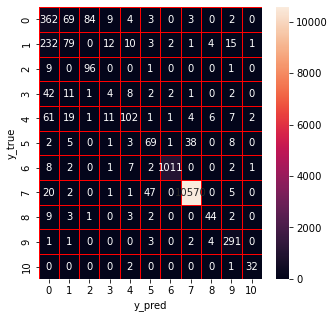

In [67]:
start_time = time.time()
stk = xgb.XGBClassifier().fit(x_train, y_train)
end_time = time.time()
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': stk_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Time': end_time-start_time
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('Stacking (Original)')

#### Hyperparameter optimization (HPO) of the stacking ensemble model (XGBoost) using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [68]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

start_time = time.time()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

end_time = time.time()

print("XGBoost: Hyperopt estimated optimum {}".format(best))

[20:35:13] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:35:21] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:35:22] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:35:23] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation

[20:36:45] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBoost: 0.938064898503482
Precision of XGBoost: 0.9381270173648902
Recall of XGBoost: 0.938064898503482
F1-score of XGBoost: 0.9356932609211833
              precision    recall  f1-score   support

           0       0.49      0.68      0.57       536
           1       0.42      0.22      0.29       359
           2       0.52      0.90      0.66       107
           3       0.11      0.05      0.07        73
           4       0.73      0.47      0.57       215
           5       0.52      0.54      0.53       127
           6       0.99      0.98      0.99      1034
           7       1.00      0.99      0.99     10646
           8       0.76      0.69      0.72        64
           9

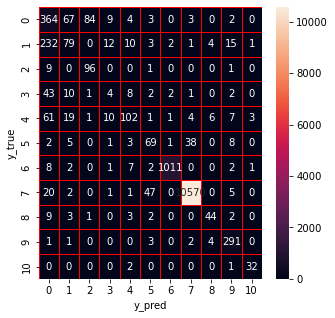

In [69]:
params = {
    'n_estimators': int(best['n_estimators']), 
    'max_depth': int(best['max_depth']),
    'learning_rate':  abs(float(best['learning_rate'])),
}
xg = xgb.XGBClassifier(**params)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': xg_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Time': end_time-start_time
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('Stacking (BO-TPE)')

#### Hyperparameter optimization (HPO) of stacking ensemble model (XGBoost) using Particle Swarm Optimization (PSO)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
#XGBoost
import optunity
import optunity.metrics

data= X_combined
labels= y_combined.tolist()
Y_train = y_train
Y_test = y_test
# Define the hyperparameter configuration space
search = {
    'n_estimators': [10, 100],
    'max_depth': [5,50],
    'learning_rate': [0.01, 0.9]
}
# Define the objective function
@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance(x_train, y_train, x_test, y_test,n_estimators=None, max_depth=None,learning_rate=None):
    # fit the model
    params = {
        'n_estimators': int(n_estimators), 
        'max_depth': int(max_depth),
        'learning_rate':  abs(float(learning_rate)),
    }
    model = xgb.XGBClassifier( **params)
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    # scores=np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
    #                                 scoring="accuracy"))
    #return optunity.metrics.roc_auc(y_test, predictions, positive=True)
    return optunity.metrics.accuracy(Y_test, predictions)

start_time = time.time()

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )

end_time = time.time()

print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

In [ ]:
params = {
    'n_estimators': int(optimal_configuration['n_estimators']), 
    'max_depth': int(optimal_configuration['max_depth']), 
    'learning_rate': abs(float(optimal_configuration['learning_rate']))
}
xg = xgb.XGBClassifier(**params)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': xg_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Time': end_time-start_time
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('Stacking (PSO)')

#### Hyperparameter optimization (HPO) of stacking ensemble model (XGBoost) using Genetic Algorithm (GA)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
#XGBoost
from tpot import TPOTClassifier
# Define the hyperparameter configuration space
parameters = {
    'n_estimators': range(10,100),
    'max_depth': range(4,100),
    'learning_rate': [i/100 for i in range(1, 90)]
}
# Set the hyperparameters of GA                 
ga = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'xgboost.XGBClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
start_time = time.time()
ga.fit(X_combined, y_combined)
end_time = time.time()

In [ ]:
xg = xgb.XGBClassifier(**get_ga_optimized_parameters(ga, 'XGBClassifier'))
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
# Add to output sheet
result_dict = {
    'Accuracy': xg_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Time': end_time-start_time
}
output_df = output_df.append(result_dict, ignore_index=True)
# Add index name
output_index.append('Stacking (GA)')

In [ ]:
# Rename the index
output_df.index = output_index
# Save the result to file
import datetime
output_df.to_excel('result-{}.xlsx'.format(datetime.datetime.now().strftime('%y%m%d-%H%M%S')))

## Anomaly-based IDS

### Generate the port-scan datasets for unknown attack detection

In [91]:
# df=pd.read_csv('./data/UNSW-NB15_sample_km.csv')

In [92]:
# df['attack_cat'].value_counts()

7     53253
6      5190
0      2677
1      1795
9      1511
4      1008
5       588
2       534
3       399
8       360
10      174
Name: attack_cat, dtype: int64

In [93]:
# df1 = df[df['attack_cat'] != 9]
# df1['attack_cat'][df1['attack_cat'] != 7] = 1
# df1.to_csv('./data/UNSW-NB15_sample_km_without_shellcode.csv',index=0)

In [94]:
# df2 = df[df['attack_cat'] == 9]
# df2['attack_cat'][df2['attack_cat'] == 9] = 1
# df2.to_csv('./data/UNSW-NB15_sample_km_shellcode.csv',index=0)

### Read the generated datasets for unknown attack detection

In [95]:
# df1 = pd.read_csv('./data/UNSW-NB15_sample_km_without_shellcode.csv')
# df2 = pd.read_csv('./data/UNSW-NB15_sample_km_shellcode.csv')

In [96]:
# features = df1.drop(['attack_cat'],axis=1).dtypes[df1.dtypes != 'object'].index
# df1[features] = df1[features].apply(
#     lambda x: (x - x.mean()) / (x.std()))
# df2[features] = df2[features].apply(
#     lambda x: (x - x.mean()) / (x.std()))
# df1 = df1.fillna(0)
# df2 = df2.fillna(0)

In [97]:
# df1['attack_cat'].value_counts()

7    53253
1    12725
Name: attack_cat, dtype: int64

In [98]:
# df2['attack_cat'].value_counts()

1    1511
Name: attack_cat, dtype: int64

In [99]:
# df2p=df1[df1['attack_cat']==7]
# df2pp=df2p.sample(n=None, frac=1511/53253, replace=False, weights=None, random_state=None, axis=0)
# df2=pd.concat([df2, df2pp])

In [100]:
# df2['attack_cat'].value_counts()

1    1511
7    1511
Name: attack_cat, dtype: int64

In [101]:
# df = df1.append(df2)

In [102]:
# X = df.drop(['attack_cat'],axis=1).values
# y = df.iloc[:, -1].values.reshape(-1,1)
# y=np.ravel(y)
# pd.Series(y).value_counts()

7    54764
1    14236
dtype: int64

### Feature engineering (IG, FCBF, and KPCA)

#### Feature selection by information gain (IG)

In [103]:
# from sklearn.feature_selection import mutual_info_classif
# importances = mutual_info_classif(X, y)

In [104]:
# # calculate the sum of importance scores
# f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
# Sum = 0
# fs = []
# for i in range(0, len(f_list)):
#     Sum = Sum + f_list[i][0]
#     fs.append(f_list[i][1])

In [105]:
# # select the important features from top to bottom until the accumulated importance reaches 90%
# f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
# Sum2 = 0
# fs = []
# for i in range(0, len(f_list2)):
#     Sum2 = Sum2 + f_list2[i][0]
#     fs.append(f_list2[i][1])
#     if Sum2>=0.9:
#         break        

In [106]:
# X_fs = df[fs].values

In [107]:
# X_fs.shape

(69000, 30)

In [108]:
# X_fs

array([[-0.5157852 , -0.11993092, -0.47661465, ..., -1.12489896,
         1.06853583, -0.14827844],
       [-0.5157852 , -0.12107443, -0.47661465, ..., -1.12489896,
         1.06853583, -0.27440478],
       [-0.5157852 , -0.12164619, -0.47661465, ..., -1.12489896,
         1.06853583, -0.27440478],
       ...,
       [-0.17877201, -0.13079427, -0.47661465, ..., -1.12489896,
        -0.82616322,  1.49136388],
       [-0.5157852 , -0.10320709, -0.47661465, ...,  0.88895526,
        -0.82616322, -0.65278377],
       [-0.5157852 ,  1.18853067, -0.47661465, ...,  0.88895526,
        -0.82616322, -0.65278377]])

#### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [109]:
# from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
# fcbf = FCBFK(k = 20)
# #fcbf.fit(X_fs, y)

In [110]:
# X_fss = fcbf.fit_transform(X_fs,y)

In [111]:
# X_fss.shape

(69000, 20)

In [112]:
# X_fss

array([[-0.47661465, -0.5157852 , -0.06975683, ..., -0.34709766,
        -0.4143315 , -0.26561907],
       [-0.47661465, -0.5157852 , -0.06975683, ..., -0.33097366,
        -0.4143315 , -0.26561907],
       [-0.47661465, -0.5157852 , -0.06975683, ..., -0.3375741 ,
        -0.4143315 , -0.26561907],
       ...,
       [-0.47661465, -0.17877201, -0.64650816, ...,  0.71506847,
        -0.44488475, -0.26561907],
       [-0.47661465, -0.5157852 , -0.06975683, ..., -0.3336002 ,
        -0.29211847, -0.19592477],
       [-0.47661465, -0.5157852 , -0.06975683, ..., -0.23107668,
         0.31894669, -0.12623047]])

####  kernel principal component analysis (KPCA)

In [113]:
# from sklearn.decomposition import KernelPCA
# kpca = KernelPCA(n_components = 10, kernel = 'rbf')
# kpca.fit(X_fss, y)
# X_kpca = kpca.transform(X_fss)

# # from sklearn.decomposition import PCA
# # kpca = PCA(n_components = 10)
# # kpca.fit(X_fss, y)
# # X_kpca = kpca.transform(X_fss)

MemoryError: Unable to allocate 35.5 GiB for an array with shape (69000, 69000) and data type float64

### Train-test split after feature selection

In [86]:
# X_train = X_kpca[:len(df1)]
# y_train = y[:len(df1)]
# X_test = X_kpca[len(df1):]
# y_test = y[len(df1):]

### Solve class-imbalance by SMOTE

In [87]:
# pd.Series(y_train).value_counts()

0    18225
1     7320
dtype: int64

In [88]:
# from imblearn.over_sampling import SMOTE
# smote=SMOTE(n_jobs=-1,sampling_strategy={1:18225})
# X_train, y_train = smote.fit_sample(X_train, y_train)

In [89]:
# pd.Series(y_train).value_counts()

1    18225
0    18225
dtype: int64

In [90]:
# pd.Series(y_test).value_counts()

1    1255
0    1255
dtype: int64

### Apply the cluster labeling (CL) k-means method

In [91]:
# from sklearn.cluster import KMeans
# from sklearn.cluster import DBSCAN,MeanShift
# from sklearn.cluster import SpectralClustering,AgglomerativeClustering,AffinityPropagation,Birch,MiniBatchKMeans,MeanShift 
# from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
# from sklearn.metrics import classification_report
# from sklearn import metrics

In [124]:
# def CL_kmeans(X_train, X_test, y_train, y_test,n,b=100):
#     km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
#     result = km_cluster.fit_predict(X_train)
#     result2 = km_cluster.predict(X_test)

#     count=0
#     a=np.zeros(n)
#     b=np.zeros(n)
#     for v in range(0,n):
#         for i in range(0,len(y_train)):
#             if result[i]==v:
#                 if y_train[i]==1:
#                     a[v]=a[v]+1
#                 else:
#                     b[v]=b[v]+1
#     list1=[]
#     list2=[]
#     for v in range(0,n):
#         if a[v]<=b[v]:
#             list1.append(v)
#         else: 
#             list2.append(v)
#     for v in range(0,len(y_test)):
#         if result2[v] in list1:
#             result2[v]=0
#         elif result2[v] in list2:
#             result2[v]=1
#         else:
#             print("-1")
#     print(classification_report(y_test, result2))
#     cm=confusion_matrix(y_test,result2)
#     acc=metrics.accuracy_score(y_test,result2)
#     print(str(acc))
#     print(cm)

In [94]:
# CL_kmeans(X_train, X_test, y_train, y_test, 8)

              precision    recall  f1-score   support

           0       0.58      0.69      0.63      1255
           1       0.62      0.51      0.56      1255

    accuracy                           0.60      2510
   macro avg       0.60      0.60      0.60      2510
weighted avg       0.60      0.60      0.60      2510

0.5984063745019921
[[864 391]
 [617 638]]


### Hyperparameter optimization of CL-k-means
Tune "k"

In [120]:
# #Hyperparameter optimization by BO-GP
# from skopt.space import Real, Integer
# from skopt.utils import use_named_args
# from sklearn import metrics

# space  = [Integer(2, 50, name='n_clusters')]
# @use_named_args(space)
# def objective(**params):
#     km_cluster = MiniBatchKMeans(batch_size=100, **params)
#     n=params['n_clusters']
    
#     result = km_cluster.fit_predict(X_train)
#     result2 = km_cluster.predict(X_test)

#     count=0
#     a=np.zeros(n)
#     b=np.zeros(n)
#     for v in range(0,n):
#         for i in range(0,len(y_train)):
#             if result[i]==v:
#                 if y_train[i]==1:
#                     a[v]=a[v]+1
#                 else:
#                     b[v]=b[v]+1
#     list1=[]
#     list2=[]
#     for v in range(0,n):
#         if a[v]<=b[v]:
#             list1.append(v)
#         else: 
#             list2.append(v)
#     for v in range(0,len(y_test)):
#         if result2[v] in list1:
#             result2[v]=0
#         elif result2[v] in list2:
#             result2[v]=1
#         else:
#             print("-1")
#     cm=metrics.accuracy_score(y_test,result2)
#     print(str(n)+" "+str(cm))
#     return (1-cm)
# from skopt import gp_minimize
# import time
# t1=time.time()
# res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
# t2=time.time()
# print(t2-t1)
# print("Best score=%.4f" % (1-res_gp.fun))
# print("""Best parameters: n_clusters=%d""" % (res_gp.x[0]))

30 0.6972111553784861
43 0.7127490039840637
43 0.399203187250996
43 0.47051792828685257
32 0.653784860557769
20 0.34860557768924305
16 0.9195219123505977
5 0.4370517928286853
15 0.6729083665338645
25 0.7063745019920319
2 0.47808764940239046
50 0.4199203187250996


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2 0.47768924302788845


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


50 0.39282868525896414
17 0.42828685258964144


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2 0.47768924302788845


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2 0.47768924302788845


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


16 0.6992031872509961


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


16 0.3737051792828685


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


50 0.6250996015936255
9.127083539962769
Best score=0.9195
Best parameters: n_clusters=16


In [121]:
# #Hyperparameter optimization by BO-TPE
# from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
# from sklearn.model_selection import cross_val_score, StratifiedKFold
# from sklearn.cluster import MiniBatchKMeans
# from sklearn import metrics

# def objective(params):
#     params = {
#         'n_clusters': int(params['n_clusters']), 
#     }
#     km_cluster = MiniBatchKMeans(batch_size=100, **params)
#     n=params['n_clusters']
    
#     result = km_cluster.fit_predict(X_train)
#     result2 = km_cluster.predict(X_test)

#     count=0
#     a=np.zeros(n)
#     b=np.zeros(n)
#     for v in range(0,n):
#         for i in range(0,len(y_train)):
#             if result[i]==v:
#                 if y_train[i]==1:
#                     a[v]=a[v]+1
#                 else:
#                     b[v]=b[v]+1
#     list1=[]
#     list2=[]
#     for v in range(0,n):
#         if a[v]<=b[v]:
#             list1.append(v)
#         else: 
#             list2.append(v)
#     for v in range(0,len(y_test)):
#         if result2[v] in list1:
#             result2[v]=0
#         elif result2[v] in list2:
#             result2[v]=1
#         else:
#             print("-1")
#     score=metrics.accuracy_score(y_test,result2)
#     print(str(params['n_clusters'])+" "+str(score))
#     return {'loss':1-score, 'status': STATUS_OK }
# space = {
#     'n_clusters': hp.quniform('n_clusters', 2, 50, 1),
# }

# best = fmin(fn=objective,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=20)
# print("Random Forest: Hyperopt estimated optimum {}".format(best))

23 0.34422310756972113
15 0.6685258964143427
46 0.450199203187251
15 0.4896414342629482
29 0.6824701195219124
36 0.3888446215139442
22 0.35776892430278884
25 0.34860557768924305
42 0.41832669322709165
27 0.47051792828685257
26 0.39402390438247015
25 0.6824701195219124
33 0.3848605577689243
19 0.7191235059760956
6 0.5824701195219123
21 0.6697211155378486
24 0.451394422310757
37 0.4681274900398406
14 0.47250996015936253
21 0.8434262948207172
100%|███████████████████████████████████████████████| 20/20 [00:06<00:00,  2.87trial/s, best loss: 0.15657370517928282]
Random Forest: Hyperopt estimated optimum {'n_clusters': 21.0}


In [122]:
# CL_kmeans(X_train, X_test, y_train, y_test, 16)

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1255
           1       0.91      0.99      0.95      1255

    accuracy                           0.95      2510
   macro avg       0.95      0.95      0.94      2510
weighted avg       0.95      0.95      0.94      2510

0.9450199203187251
[[1127  128]
 [  10 1245]]


### Apply the CL-k-means model with biased classifiers

In [125]:
# # needs to work on the entire dataset to generate sufficient training samples for biased classifiers
# def Anomaly_IDS(X_train, X_test, y_train, y_test,n,b=100):
#     # CL-kmeans
#     km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
#     result = km_cluster.fit_predict(X_train)
#     result2 = km_cluster.predict(X_test)

#     count=0
#     a=np.zeros(n)
#     b=np.zeros(n)
#     for v in range(0,n):
#         for i in range(0,len(y_train)):
#             if result[i]==v:
#                 if y_train[i]==1:
#                     a[v]=a[v]+1
#                 else:
#                     b[v]=b[v]+1
#     list1=[]
#     list2=[]
#     for v in range(0,n):
#         if a[v]<=b[v]:
#             list1.append(v)
#         else: 
#             list2.append(v)
#     for v in range(0,len(y_test)):
#         if result2[v] in list1:
#             result2[v]=0
#         elif result2[v] in list2:
#             result2[v]=1
#         else:
#             print("-1")
#     print(classification_report(y_test, result2))
#     cm=confusion_matrix(y_test,result2)
#     acc=metrics.accuracy_score(y_test,result2)
#     print(str(acc))
#     print(cm)
    
#     #Biased classifier construction
#     count=0
#     print(len(y))
#     a=np.zeros(n)
#     b=np.zeros(n)
#     FNL=[]
#     FPL=[]
#     for v in range(0,n):
#         al=[]
#         bl=[]
#         for i in range(0,len(y)):   
#             if result[i]==v:        
#                 if y[i]==1:        #label 1
#                     a[v]=a[v]+1
#                     al.append(i)
#                 else:             #label 0
#                     b[v]=b[v]+1
#                     bl.append(i)
#         if a[v]<=b[v]:
#             FNL.extend(al)
#         else:
#             FPL.extend(bl)
#         #print(str(v)+"="+str(a[v]/(a[v]+b[v])))
        
#     dffp=df.iloc[FPL, :]
#     dffn=df.iloc[FNL, :]
#     dfva0=df[df['Label']==0]
#     dfva1=df[df['Label']==1]
    
#     dffpp=dfva1.sample(n=None, frac=len(FPL)/dfva1.shape[0], replace=False, weights=None, random_state=None, axis=0)
#     dffnp=dfva0.sample(n=None, frac=len(FNL)/dfva0.shape[0], replace=False, weights=None, random_state=None, axis=0)
    
#     dffp_f=pd.concat([dffp, dffpp])
#     dffn_f=pd.concat([dffn, dffnp])
    
#     Xp = dffp_f.drop(['Label'],axis=1)  
#     yp = dffp_f.iloc[:, -1].values.reshape(-1,1)
#     yp=np.ravel(yp)

#     Xn = dffn_f.drop(['Label'],axis=1)  
#     yn = dffn_f.iloc[:, -1].values.reshape(-1,1)
#     yn=np.ravel(yn)
    
#     rfp = RandomForestClassifier(random_state = 0)
#     rfp.fit(Xp,yp)
#     rfn = RandomForestClassifier(random_state = 0)
#     rfn.fit(Xn,yn)

#     dffnn_f=pd.concat([dffn, dffnp])
    
#     Xnn = dffn_f.drop(['Label'],axis=1)  
#     ynn = dffn_f.iloc[:, -1].values.reshape(-1,1)
#     ynn=np.ravel(ynn)

#     rfnn = RandomForestClassifier(random_state = 0)
#     rfnn.fit(Xnn,ynn)

#     X2p = df2.drop(['Label'],axis=1) 
#     y2p = df2.iloc[:, -1].values.reshape(-1,1)
#     y2p=np.ravel(y2p)

#     result2 = km_cluster.predict(X2p)

#     count=0
#     a=np.zeros(n)
#     b=np.zeros(n)
#     for v in range(0,n):
#         for i in range(0,len(y)):
#             if result[i]==v:
#                 if y[i]==1:
#                     a[v]=a[v]+1
#                 else:
#                     b[v]=b[v]+1
#     list1=[]
#     list2=[]
#     l1=[]
#     l0=[]
#     for v in range(0,n):
#         if a[v]<=b[v]:
#             list1.append(v)
#         else: 
#             list2.append(v)
#     for v in range(0,len(y2p)):
#         if result2[v] in list1:
#             result2[v]=0
#             l0.append(v)
#         elif result2[v] in list2:
#             result2[v]=1
#             l1.append(v)
#         else:
#             print("-1")
#     print(classification_report(y2p, result2))
#     cm=confusion_matrix(y2p,result2)
#     print(cm)

More details are in the paper